# Fine-tune R-CNN model for Cereal Killer
Based on: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [4]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from engine import train_one_epoch, evaluate
# import utils
import matplotlib.pyplot as plt


## Create train, validation, and test sets
---

In [5]:
class CerealKillerDataset(object):
    def __init__(self, root, all_targets, transform=None):
        self.root = root
        self.transform = transform
        #load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNG"))))
        
        self.all_targets = all_targets
        
    def __getitem__(self, idx):
        # img filename
        img_file = self.imgs[idx]
        # load images and labels
        img_path = os.path.join(self.root, "PNG", img_file)
        # open image
        img = Image.open(img_path).convert("RGB")
        # get target info for this image
        targets = self.all_targets[img_file]
        
        
        # get class and bounding box coordinates
        label_names = []
        label_ids = []
        boxes = []
        for target in targets:
            label_names.append(target['class_name'])
            label_ids.append(target['class_id'])
            boxes.append(target['bbox'])

        # convert target into to torch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        image_id = torch.tensor([idx])
        label_ids = torch.as_tensor(label_ids, dtype=torch.int64)
        
        # create dictionary of target info
        target = {}
        target["boxes"] = boxes
        target["image_id"] = image_id
        target["labels"] = label_ids
        target["label_names"] = label_names

        if self.transform:                                     # If a transformation function was provided,
            img = self.transform(img)                          #   Apply a transformation to the image

        return img, target

    def __len__(self):
        return len(self.imgs)

### Load target info (bounding boxes and classes for all images)

In [6]:
target_path = os.path.join('..', 'data', 'synthesized', 'targets.npy')
all_targets = np.load(target_path, allow_pickle=True)[()]

# look at target infor for first image
all_targets['00000.png']

[{'class_name': 'CTC', 'class_id': 2, 'bbox': [167, 97, 212, 158]},
 {'class_name': 'AJS', 'class_id': 7, 'bbox': [65, 24, 151, 146]},
 {'class_name': 'CHX', 'class_id': 14, 'bbox': [7, 43, 63, 131]},
 {'class_name': 'CHX', 'class_id': 14, 'bbox': [60, 152, 96, 209]},
 {'class_name': 'HNC', 'class_id': 4, 'bbox': [178, 27, 218, 88]}]

### Plot image from CerealKillerDataset to ensure it's working properly

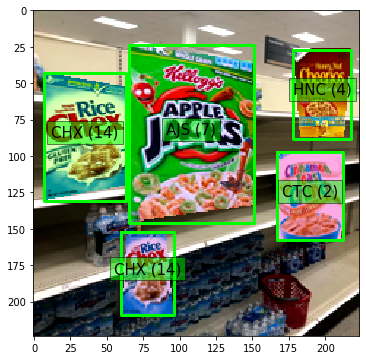

In [7]:
train_dataset = CerealKillerDataset('../Data/synthesized', all_targets)

# get random image
img, target = train_dataset[0]

# plot
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(np.array(img));

for box, label_name, label in zip(target['boxes'], target['label_names'], target['labels']):
    ax.plot([box[0],box[2], box[2],box[0],box[0]], [box[1],box[1],box[3],box[3],box[1]], linewidth=3, color='lime')
    ax.text(np.mean([box[0], box[2]]), np.mean([box[1],box[3]]), f'{label_name} ({str(label.item())})', fontsize=15, bbox=dict(facecolor='lime', alpha=0.5), horizontalalignment='center')

### Calculate mean and std. dev. of pixel values across dataset

In [8]:
simple_transform = T.Compose([
    T.ToTensor()
])

train_dataset = CerealKillerDataset('../Data/synthesized', all_targets, transform=simple_transform)
mean = 0.
std = 0.
for img, _ in train_dataset:
    mean += img.mean([1,2])
    std += img.std([1,2])
mean /= len(train_dataset)
std /= len(train_dataset)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.5189, 0.4546, 0.3909])
Std: tensor([0.2370, 0.2326, 0.2393])


### Add normalization transorm to `simple_transform` function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Img Mean: 0.08
Img Std: 0.91


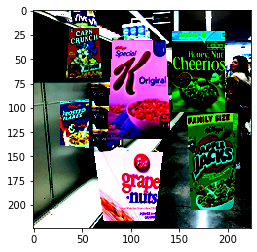

In [9]:
simple_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5189, 0.4546, 0.3909],   # Normalize an image with channel-wise means
                std=[0.2370, 0.2326, 0.2393])    #   and standard deviations
])

train_dataset = CerealKillerDataset('../Data/synthesized', all_targets, transform=simple_transform)

img, target = train_dataset[10]
plt.imshow(img.permute(1, 2, 0));

print(f'Img Mean: {img.mean():.2f}')    # Calculate the mean of the pixel values in the image
print(f'Img Std: {img.std():.2f}')      # Calculate the standard deviation of the pixel values in the image

### Define transforms for training and testing

In [10]:
train_transform = T.Compose([
    T.RandomVerticalFlip(),                      # Flip the image vertically
    T.RandomHorizontalFlip(),                    # Flip the image horizontally
    T.ToTensor(),
    T.Normalize(mean=[0.5189, 0.4546, 0.3909],   # Normalize an image with channel-wise means
                std=[0.2370, 0.2326, 0.2393])    #   and standard deviations
])

test_transform = simple_transform

### Make train, validate, test sets
Allocations: Train = 68%; Validation = 12%; Test = 20%

In [11]:
# First, load all data in each
train_dataset = CerealKillerDataset('../Data/synthesized', all_targets, transform=train_transform)
val_dataset = CerealKillerDataset('../Data/synthesized', all_targets, transform=test_transform)
test_dataset = CerealKillerDataset('../Data/synthesized', all_targets, transform=test_transform)

# Now split
num_data = len(train_dataset)
indices = torch.randperm(num_data).tolist()

train_dataset = torch.utils.data.Subset(train_dataset, indices[:np.int(np.floor(num_data * 0.68))])
val_dataset = torch.utils.data.Subset(val_dataset, indices[np.int(np.floor(num_data * 0.68)):np.int(np.floor(num_data * 0.8))])
test_dataset = torch.utils.data.Subset(test_dataset, indices[np.int(np.floor(num_data * 0.8)):])

## Training
---

### Test the `forward()` method

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = CerealKillerDataset('../Data/synthesized', all_targets, transform=train_transform)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>)}]

### Set model and training parameters

In [13]:
num_epochs = 10
learning_rate = 0.005
momentum = 0.9
weight_decay=0.0005
batchsize = 10
num_workers = 4

# Load Faster R-CNN model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# number of classes
classes = []
for key in all_targets.keys():
    for subdict in all_targets[key]:
        classes.append(subdict['class_id'])
classes = np.unique(classes)    
num_classes = len(classes)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Send the model to the computing device (train on CPU if GPU not available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
# Create train and val dataloaders that handle batchsize, shuffling the dataset each epoch, and multicore processing.
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batchsize, shuffle=True, num_workers=num_workers)       